<a href="https://colab.research.google.com/github/cs-dan/Self-Projects/blob/main/KatakanaModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Before running code (first script), upload the datasets into colab, they can be found in the given link:
#https://colab.research.google.com/drive/14sFiBgKDV-fQUNV6ckPRyxZtm5Ohew4n?usp=sharing
#
#Upload KatakanaR.npz for the first script.
#Upload weightsKatakana.npy for the second script to see accuracy for best trained weights so far.

Streaming output truncated to the last 5000 lines.
Loss is:  0.013121807109651296  at  767  iteration(s) at  ネ .
Loss is:  0.07917629238221331  at  768  iteration(s) at  キ .
Loss is:  0.05670296726260471  at  769  iteration(s) at  チ .
Loss is:  0.009761682514378789  at  770  iteration(s) at  エ .
Loss is:  0.02140647535670262  at  771  iteration(s) at  サ .
Loss is:  0.024977663326126026  at  772  iteration(s) at  ク .
Loss is:  0.0018620006154443328  at  773  iteration(s) at  イ .
Loss is:  0.0508987327796343  at  774  iteration(s) at  ヤ .
Loss is:  0.04245359671594578  at  775  iteration(s) at  シ .
Loss is:  0.08533642369542693  at  776  iteration(s) at  セ .
Loss is:  0.02761935651017629  at  777  iteration(s) at  ロ .
Loss is:  0.045469842942035654  at  778  iteration(s) at  サ .
Loss is:  0.061257014237783396  at  779  iteration(s) at  ホ .
Loss is:  0.014894741803391419  at  780  iteration(s) at  ヨ .
Loss is:  0.0008156082466519715  at  781  iteration(s) at  ハ .
Loss is:  0.0802250629472

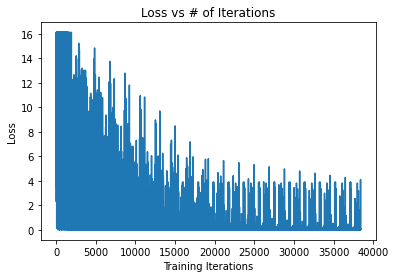

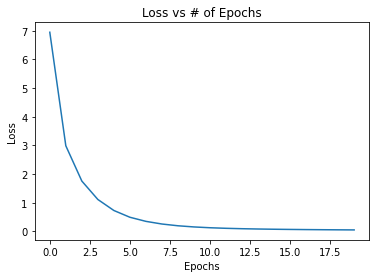

In [ ]:
####################################################################
######################### Katakana Program #########################
####################################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

################################################################################
######################### Convolution Neural Net Class #########################
#regarding weightMatrix, layerMatrix, derivativeMatrix
#defined as ""matrix[layer][(row,)-matrix] for layerMatrix/derivativeMatrix, where row = # of nodes 
#defined as ""matrix[layer][(row,col)-matrix] for weightMatrix/derivativeMatrix, where row = size of flattened sample, col = # of nodes


class cnn(object):
  def __init__(self, learning_rate=0.0005):
    self.c = learning_rate
    self.weightMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))]  #list holding weights from each time weight was called.
    self.layerMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding node values from each dense layer 
    self.derivativeMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding derivatives for each layer
    self.char = ['ア','イ','ウ','エ','オ','カ','キ','ク','ケ','コ','サ','シ','ス','セ','ソ','タ','チ','ツ','テ','ト','ナ','ニ','ヌ','ネ','ノ','ハ','ヒ','フ','ヘ','ホ','マ','ミ','ム','メ','モ','ヤ','ユ','ヨ','ラ','リ','ル','レ','ロ','ワ','ヰ','ヱ','ヲ','ン',]
    self.correct = 0
    self.accuracyF = np.empty(shape=(0,), dtype=float)
    self.lossF = np.empty(shape=(0,), dtype=float)

  def conv1(self, input, kernel_size=(3,3), strides=(1,1), padding = 2):
    input = input
    kernel1 = np.array([[[0,-3,0],[-3,15,-3],[0,-3,0]]]) #sharpening filter
    kernel2 = np.array([[[-5,-15,-5],[0,0,0],[5,15,5]]]) #vertical filter
    kernel3 = np.array([[[-5,0,5],[-15,0,15],[-5,0,5]]]) #horizontal filter    
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(filter.shape[0], input.shape[0]-2, input.shape[1]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(filter.shape[0]): #per kernel
      for j in range(input.shape[0] - 2 ):  #rows
        for k in range(input.shape[1] - 2 ): #columns 
          window = input[j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation  
    return output
  
  def conv2(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[[0,-1,0],[-1,5,-1],[0,-1,0]]]) #vertical filter
    kernel2 = np.array([[[-1,-2,-1],[0,0,0],[1,2,1]]]) #vertical filter
    kernel3 = np.array([[[-1,0,1],[-2,0,2],[-1,0,1]]]) #horizontal filter
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]):
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) 
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def conv3(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #sharpening filter
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]): #per kernel
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, kernel1)) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def pooling(self, input, pool_size=(2,2), strides=(2,2)):
    """pooling layer to grab largest values"""
    self.arr = input  #input set of convoluted images 
    output = np.zeros(shape=(input.shape[0], int(input.shape[1]/strides[0]), int(input.shape[2]/strides[1]))) #shape of output
    for i in range(self.arr.shape[0]): #per feature map
      for j in range(0, self.arr.shape[1], strides[0]): #rows
        for k in range(0, self.arr.shape[2], strides[1]): #columns
          if int(j/2) >= output.shape[1] or int(k/2) >= output.shape[2]: break
          window = self.arr[i, j:j+strides[0], k:k+strides[1]]   #select window    #mistake: you set self.arr to np.arr instead, generating random vals
          output[i,int(j/2),int(k/2)] = np.max(window)   #get max from window
    return output   #output pool layers

  def flatten(self, input):
    """Reshape feature maps into 1d layer"""
    output = np.reshape(input, input.size)    #reshape all array elements into a 1d array
    return output #output flattened layers

  def denseSetup(self, input, layers, nodes, skip=False):
    """fully connected layers setup"""
    random = np.random.RandomState(1)
    self.layerMatrix[0] = np.zeros(shape=(input.size+1,))
    self.layerMatrix[1] = np.zeros(shape=(nodes[0],))
    self.layerMatrix[2] = np.zeros(shape=(nodes[1],))
    for i in range(layers):
      if skip == False:
        self.weightMatrix[i] = random.normal(loc=0.0, scale=0.1, size=(self.layerMatrix[i].shape[0], nodes[i])) #weights per node
      self.derivativeMatrix[i] = np.zeros(shape=(nodes[i],)) #layer derivatives 
  
  def denseNetwork(self, input): 
    """fully connected layers, 3 in total"""
    self.layerMatrix[0] = input  #input layer
    self.layerMatrix[0] = np.append(self.layerMatrix[0], 1) #append bias
    self.layerMatrix[0] = self.layerMatrix[0] / 10  #scale by 10
    l=0
    for l in range(len(self.layerMatrix)-1):
      next = l + 1
      for i in range(self.layerMatrix[next].shape[0]):  #next layer num nodes
        if next == len(self.layerMatrix)-1: 
          self.layerMatrix[next][i] = np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i])
        else: 
          self.layerMatrix[next][i] = self.ReLu(np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i]))
    self.layerMatrix[2] = self.softMax(self.layerMatrix[len(self.layerMatrix)-1]) #output layer
    self.layerMatrix[2][np.abs(self.layerMatrix[2]) < 1e-7] = 1e-7 #array[np.abs(array) < eps] = 0
    self.biggest = np.argmax(self.layerMatrix[2])
    return self.layerMatrix[2]

  def denseBack(self, loss):
    """backpropagation function through all fully connected layers"""
    derivative1 = np.zeros(shape=(self.layerMatrix[2].shape[0]))  #derivative array at output
    derivative2 = np.zeros(shape=(self.layerMatrix[1].shape[0]))  #derivative array at hidden

    #output layer to hidden layer 
    for i in range(self.layerMatrix[1].shape[0]):  #for layer below current (hidden)
      for j in range(self.layerMatrix[2].shape[0]):  #for current layer (output)
        derivative1[j] = -self.target[j] + self.layerMatrix[2][j]   #crossentropy loss - softmax derivative
        dLayer = self.layerMatrix[1][i]*derivative1[j]*self.c #- self.m*derivative1[j]  #activation*derivative*learning rate
        self.weightMatrix[1][i,j] -= dLayer

    #hidden layer to flatten layer 
    for i in range(self.layerMatrix[0].shape[0]):
      for j in range(self.layerMatrix[1].shape[0]):
        derivative2[j] = np.greater(self.layerMatrix[1][j], 0).astype(int)*np.dot(derivative1, self.weightMatrix[1][j])  #relu - past derivative derivative
        dLayer = self.layerMatrix[0][i]*derivative2[j]*self.c #- self.m*derivative2[j]
        self.weightMatrix[0][i,j] -= dLayer

  def ReLu(self, input):
    """ReLU function for convolution and dense layers"""
    return max(0.0, input)   #return value if greater than 0.0, otherwise return 0.0

  def Loss(self, output):  
    """cross-entropy loss"""
    return -np.sum(self.target*np.log(output))   #loss = -sum(class*ln(output))

  def softMax(self, input):   
    """softmax function on entire layer"""
    return np.exp(input)/np.sum(np.exp(input), axis=0)

  def encode(self, classes, target):
    """one hot encoding function"""
    target.fill(0) 
    target[classes] = 1
    return target

  def predictPreloaded(self, data, targets): 
    """predict function to load weights outside of training"""
    self.loadWeights()
    self.target = np.zeros((48,),dtype=int)
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      if i == 0: 
        self.denseSetup(input, layers=2,nodes=[12*12*2,48], skip=True)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == self.target[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print(self.accuracy.shape, data.shape)
    print("Predicition Accuracy Rate: ", 100*(self.correct/data.shape[0]))   #(self.accuracy.shape[0]/data.shape[0]), "%")
    self.correct = 0

  def predict(self, data, targets):
    """for predicting while training"""
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print("Prediction Accuracy Rate: ", 100*(self.accuracy.shape[0]/data.shape[0]), "%")
    self.accuracyF = np.append(self.accuracyF, 100*(self.correct/data.shape[0]))  #(self.accuracy.shape[0]/data.shape[0]))
    self.correct = 0 
  
  def fit(self, features, classes, epochs): #, valid_data):
    rest, features, restid, classes = train_test_split(images, classes, test_size=0.02668, stratify=classes)
    """main training function"""
    self.target = np.zeros((48,),dtype=int)
    self.lossE = np.zeros(shape=(0,))
    error = 100
    epochLoss = 0
    print("Starting training...")
    for e in range(epochs):
      for i in range(features.shape[0]):
        if i > 50 and np.sum(self.lossF[i-50:i])/50 <= 1e-2:
          print("Early breaking condition reached. Acceptable loss range hit.")
          print("Loss was: ", error)
          self.saveWeights()
          return self
        ##################################
        ########## forward pass ##########
        input = features[i]
        input = self.conv1(input=input)
        input = self.pooling(input=input)
        input = self.conv2(input=input)
        input = self.pooling(input=input)
        input = self.conv3(input=input)
        input = self.flatten(input=input)
        if e == 0 and i == 0: 
          self.denseSetup(input, layers=2,nodes=[384,48])
        self.target = self.encode(classes[i], self.target)
        output = self.denseNetwork(input=input)
        ##########################
        ########## loss ##########
        error = self.Loss(output)
        self.lossF = np.append(self.lossF, error) #[i] = error
        epochLoss += error
        ###############################
        ########## back pass ##########
        self.denseBack(error)
        # if i % 100 == 0 and i > 0:    #every 100 iterations, test validation data
        #   self.predict(valid_data[0][int(i/10)-10:i], valid_data[1][int(i/10)-10:i])  #features, classes) #valid_data[0], valid_data[1])
        #   print("Loss is: ", error, " at ", i, " iterations.")
        print("Loss is: ", error, " at ", i, " iteration(s) at ", self.char[classes[i]], ".")
      self.lossE = np.append(self.lossE, epochLoss/features.shape[0]) #self.lossF.size)
      epochLoss = 0
      print("Loss at epoch = ", self.lossE[e])
      print("Epoch ", e+1, " completed.")
    print("Finished!")
    self.saveWeights()
    return self
  def saveWeights(self):
    w = np.asarray(self.weightMatrix, dtype=object)
    with open('weightsKatakana.npy', 'wb') as f:
      np.save(f, w)
  
  def loadWeights(self):
    with open('weightsKatakana.npy', 'rb') as f:
      temp = np.load(f, allow_pickle=True)
    for i in range(len(self.weightMatrix)):
      self.weightMatrix[i] = temp[i]
    print(len(self.weightMatrix))
    assert len(self.weightMatrix) == 2

############################################################################
############################## Data Wrangling ##############################

loaded = np.load('katakanaR.npz')
images = loaded['a']
classes = loaded['b']
print(images.shape, classes.shape)

########################################################################
############################## Model Init ##############################

model = cnn().fit(images, classes, 20 )

##################################################################################
############################## Metric Visualization ##############################

plt.plot(model.lossF) # plotting by columns
plt.ylabel('Loss')
plt.xlabel('Training Iterations')
plt.title('Loss vs # of Iterations')
plt.show()

plt.plot(model.lossE) # plotting by columns
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs # of Epochs')
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

################################################################################
######################### Convolution Neural Net Class #########################
#regarding weightMatrix, layerMatrix, derivativeMatrix
#defined as ""matrix[layer][(row,)-matrix] for layerMatrix/derivativeMatrix, where row = # of nodes 
#defined as ""matrix[layer][(row,col)-matrix] for weightMatrix/derivativeMatrix, where row = size of flattened sample, col = # of nodes


class cnn(object):
  def __init__(self, learning_rate=0.0005):
    self.c = learning_rate
    self.weightMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))]  #list holding weights from each time weight was called.
    self.layerMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding node values from each dense layer 
    self.derivativeMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding derivatives for each layer
    self.char = ['ア','イ','ウ','エ','オ','カ','キ','ク','ケ','コ','サ','シ','ス','セ','ソ','タ','チ','ツ','テ','ト','ナ','ニ','ヌ','ネ','ノ','ハ','ヒ','フ','ヘ','ホ','マ','ミ','ム','メ','モ','ヤ','ユ','ヨ','ラ','リ','ル','レ','ロ','ワ','ヰ','ヱ','ヲ','ン',]
    #self.accuracy = np.empty(shape=(0,))
    self.correct = 0
    self.accuracyF = np.empty(shape=(0,), dtype=float)
    self.lossF = np.empty(shape=(0,), dtype=float)

  def conv1(self, input, kernel_size=(3,3), strides=(1,1), padding = 2):
    input = input
    kernel1 = np.array([[[0,-3,0],[-3,15,-3],[0,-3,0]]]) #sharpening filter
    kernel2 = np.array([[[-5,-15,-5],[0,0,0],[5,15,5]]]) #vertical filter
    kernel3 = np.array([[[-5,0,5],[-15,0,15],[-5,0,5]]]) #horizontal filter    
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(filter.shape[0], input.shape[0]-2, input.shape[1]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(filter.shape[0]): #per kernel
      for j in range(input.shape[0] - 2 ):  #rows
        for k in range(input.shape[1] - 2 ): #columns 
          window = input[j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation
    return output
  
  def conv2(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[[0,-1,0],[-1,5,-1],[0,-1,0]]]) #vertical filter
    kernel2 = np.array([[[-1,-2,-1],[0,0,0],[1,2,1]]]) #vertical filter
    kernel3 = np.array([[[-1,0,1],[-2,0,2],[-1,0,1]]]) #horizontal filter
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]):
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) 
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def conv3(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #sharpening filter
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]): #per kernel
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, kernel1)) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def pooling(self, input, pool_size=(2,2), strides=(2,2)):
    """pooling layer to grab largest values"""
    self.arr = input  #input set of convoluted images 
    output = np.zeros(shape=(input.shape[0], int(input.shape[1]/strides[0]), int(input.shape[2]/strides[1]))) #shape of output
    for i in range(self.arr.shape[0]): #per feature map
      for j in range(0, self.arr.shape[1], strides[0]): #rows
        for k in range(0, self.arr.shape[2], strides[1]): #columns
          if int(j/2) >= output.shape[1] or int(k/2) >= output.shape[2]: break
          window = self.arr[i, j:j+strides[0], k:k+strides[1]]   #select window    #mistake: you set self.arr to np.arr instead, generating random vals
          output[i,int(j/2),int(k/2)] = np.max(window)   #get max from window
    return output   #output pool layers

  def flatten(self, input):
    """Reshape feature maps into 1d layer"""
    output = np.reshape(input, input.size)    #reshape all array elements into a 1d array
    return output #output flattened layers

  def denseSetup(self, input, layers, nodes, skip=False):
    """fully connected layers setup"""
    random = np.random.RandomState(1)
    self.layerMatrix[0] = np.zeros(shape=(input.size+1,))
    self.layerMatrix[1] = np.zeros(shape=(nodes[0],))
    self.layerMatrix[2] = np.zeros(shape=(nodes[1],))
    for i in range(layers):
      if skip == False:
        self.weightMatrix[i] = random.normal(loc=0.0, scale=0.1, size=(self.layerMatrix[i].shape[0], nodes[i])) #weights per node
      self.derivativeMatrix[i] = np.zeros(shape=(nodes[i],)) #layer derivatives 
  
  def denseNetwork(self, input): 
    """fully connected layers, 3 in total"""
    self.layerMatrix[0] = input  #input layer
    self.layerMatrix[0] = np.append(self.layerMatrix[0], 1) #append bias
    self.layerMatrix[0] = self.layerMatrix[0] / 10  #scale by 10
    l=0
    for l in range(len(self.layerMatrix)-1):
      next = l + 1
      for i in range(self.layerMatrix[next].shape[0]):  #next layer num nodes
        if next == len(self.layerMatrix)-1: 
          self.layerMatrix[next][i] = np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i])
        else: 
          self.layerMatrix[next][i] = self.ReLu(np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i]))
    self.layerMatrix[2] = self.softMax(self.layerMatrix[len(self.layerMatrix)-1]) #output layer
    self.layerMatrix[2][np.abs(self.layerMatrix[2]) < 1e-7] = 1e-7 #array[np.abs(array) < eps] = 0
    self.biggest = np.argmax(self.layerMatrix[2])
    return self.layerMatrix[2]

  def denseBack(self, loss):
    """backpropagation function through all fully connected layers"""
    derivative1 = np.zeros(shape=(self.layerMatrix[2].shape[0]))  #derivative array at output
    derivative2 = np.zeros(shape=(self.layerMatrix[1].shape[0]))  #derivative array at hidden

    #output layer to hidden layer 
    for i in range(self.layerMatrix[1].shape[0]):  #for layer below current (hidden)
      for j in range(self.layerMatrix[2].shape[0]):  #for current layer (output)
        derivative1[j] = -self.target[j] + self.layerMatrix[2][j]   #crossentropy loss - softmax derivative
        dLayer = self.layerMatrix[1][i]*derivative1[j]*self.c #- self.m*derivative1[j]  #activation*derivative*learning rate
        self.weightMatrix[1][i,j] -= dLayer

    #hidden layer to flatten layer 
    for i in range(self.layerMatrix[0].shape[0]):
      for j in range(self.layerMatrix[1].shape[0]):
        derivative2[j] = np.greater(self.layerMatrix[1][j], 0).astype(int)*np.dot(derivative1, self.weightMatrix[1][j])  #relu - past derivative derivative
        dLayer = self.layerMatrix[0][i]*derivative2[j]*self.c #- self.m*derivative2[j]
        self.weightMatrix[0][i,j] -= dLayer

  def ReLu(self, input):
    """ReLU function for convolution and dense layers"""
    return max(0.0, input)   #return value if greater than 0.0, otherwise return 0.0

  def Loss(self, output):  
    """cross-entropy loss"""
    return -np.sum(self.target*np.log(output))   #loss = -sum(class*ln(output))

  def softMax(self, input):   
    """softmax function on entire layer"""
    return np.exp(input)/np.sum(np.exp(input), axis=0)

  def encode(self, classes, target):
    """one hot encoding function"""
    target.fill(0) 
    target[classes] = 1
    return target

  def predictPreloaded(self, data, targets): 
    """predict function to load weights outside of training"""
    self.loadWeights()
    self.target = np.zeros((48,),dtype=int)
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.conv3(input=input)
      input = self.flatten(input=input)
      if i == 0: 
        self.denseSetup(input, layers=2,nodes=[384,48], skip=True)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", self.char[np.argmax(output)], ", actual: ", self.char[targets[i]])
    print("Predicition Accuracy Rate: ", 100*(self.correct/data.shape[0]))   #(self.accuracy.shape[0]/data.shape[0]), "%")
    self.correct = 0

  def predict(self, data, targets):
    """for predicting while training"""
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print("Prediction Accuracy Rate: ", 100*(self.accuracy.shape[0]/data.shape[0]), "%")
    self.accuracyF = np.append(self.accuracyF, 100*(self.correct/data.shape[0]))  #(self.accuracy.shape[0]/data.shape[0]))
    self.correct = 0 
  
  def fit(self, features, classes, epochs): #, valid_data):
    """main training function"""
    self.target = np.zeros((48,),dtype=int)
    self.lossE = np.zeros(shape=(0,))
    error = 100
    epochLoss = 0
    print("Starting training...")
    for e in range(epochs):
      for i in range(features.shape[0]):
        if i > 50 and np.sum(self.lossF[i-50:i])/50 <= 1e-2:
          print("Early breaking condition reached. Acceptable loss range hit.")
          print("Loss was: ", error)
          self.saveWeights()
          return self
        ##################################
        ########## forward pass ##########
        input = features[i]
        input = self.conv1(input=input)
        input = self.pooling(input=input)
        input = self.conv2(input=input)
        input = self.pooling(input=input)
        input = self.conv3(input=input)
        input = self.flatten(input=input)
        if e == 0 and i == 0: 
          self.denseSetup(input, layers=2,nodes=[384,48])
        self.target = self.encode(classes[i], self.target)
        output = self.denseNetwork(input=input)
        ##########################
        ########## loss ##########
        error = self.Loss(output)
        self.lossF = np.append(self.lossF, error) #[i] = error
        epochLoss += error
        ###############################
        ########## back pass ##########
        self.denseBack(error)
        # if i % 100 == 0 and i > 0:    #every 100 iterations, test validation data
        #   self.predict(valid_data[0][int(i/10)-10:i], valid_data[1][int(i/10)-10:i])  #features, classes) #valid_data[0], valid_data[1])
        #   print("Loss is: ", error, " at ", i, " iterations.")
        print("Loss is: ", error, " at ", i, " iteration(s) at ", self.char[classes[i]], ".")
      self.lossE = np.append(self.lossE, epochLoss/features.shape[0]) #self.lossF.size)
      epochLoss = 0
      print("Loss at epoch = ", self.lossE[e])
      print("Epoch ", e+1, " completed.")
    print("Finished!")
    self.saveWeights()
    return self
  def saveWeights(self):
    w = np.asarray(self.weightMatrix, dtype=object)
    with open('weightsKatakana.npy', 'wb') as f:
      np.save(f, w)
  
  def loadWeights(self):
    with open('weightsKatakana.npy', 'rb') as f:
      temp = np.load(f, allow_pickle=True)
    for i in range(len(self.weightMatrix)):
      self.weightMatrix[i] = temp[i]
    assert len(self.weightMatrix) == 2

#######################################################################
############################## Data Init ##############################

loaded = np.load('katakanaR.npz')
images = loaded['a']
classes = loaded['b']
rest, features, restid, classes = train_test_split(images, classes, test_size=0.001335, stratify=classes)

########################################################################
############################## Model Init ##############################

model = cnn().predictPreloaded(features, classes)



predicted:  ス , actual:  ヘ
predicted:  カ , actual:  メ
predicted:  ス , actual:  ス
predicted:  カ , actual:  カ
predicted:  ウ , actual:  ウ
predicted:  ク , actual:  ク
predicted:  チ , actual:  チ
predicted:  シ , actual:  ン
predicted:  ト , actual:  ネ
predicted:  マ , actual:  マ
predicted:  ヌ , actual:  ヌ
predicted:  ク , actual:  ク
predicted:  イ , actual:  イ
predicted:  ル , actual:  ト
predicted:  ン , actual:  フ
predicted:  ハ , actual:  ハ
predicted:  ツ , actual:  ツ
predicted:  マ , actual:  コ
predicted:  メ , actual:  ム
predicted:  リ , actual:  リ
predicted:  ク , actual:  ケ
predicted:  チ , actual:  セ
predicted:  ヌ , actual:  ス
predicted:  ヰ , actual:  キ
predicted:  シ , actual:  シ
predicted:  ン , actual:  ヤ
predicted:  タ , actual:  ケ
predicted:  ロ , actual:  タ
predicted:  ヘ , actual:  エ
predicted:  ミ , actual:  ミ
predicted:  ノ , actual:  ノ
predicted:  ナ , actual:  チ
predicted:  ロ , actual:  ロ
predicted:  ア , actual:  ア
predicted:  ソ , actual:  ワ
predicted:  ミ , actual:  ミ
predicted:  モ , actual:  モ
p